<a href="https://colab.research.google.com/github/RJKN13/Emotion-Classification-CNN-using-Keras/blob/main/emotion_classification_cnn_using_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Importing Deep Learning Libraries

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import image_dataset_from_directory  # Use this for ImageDataGenerator functionality
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

# Displaying Images

In [74]:
picture_size = 48
folder_path = r"/content/images/train/happy"

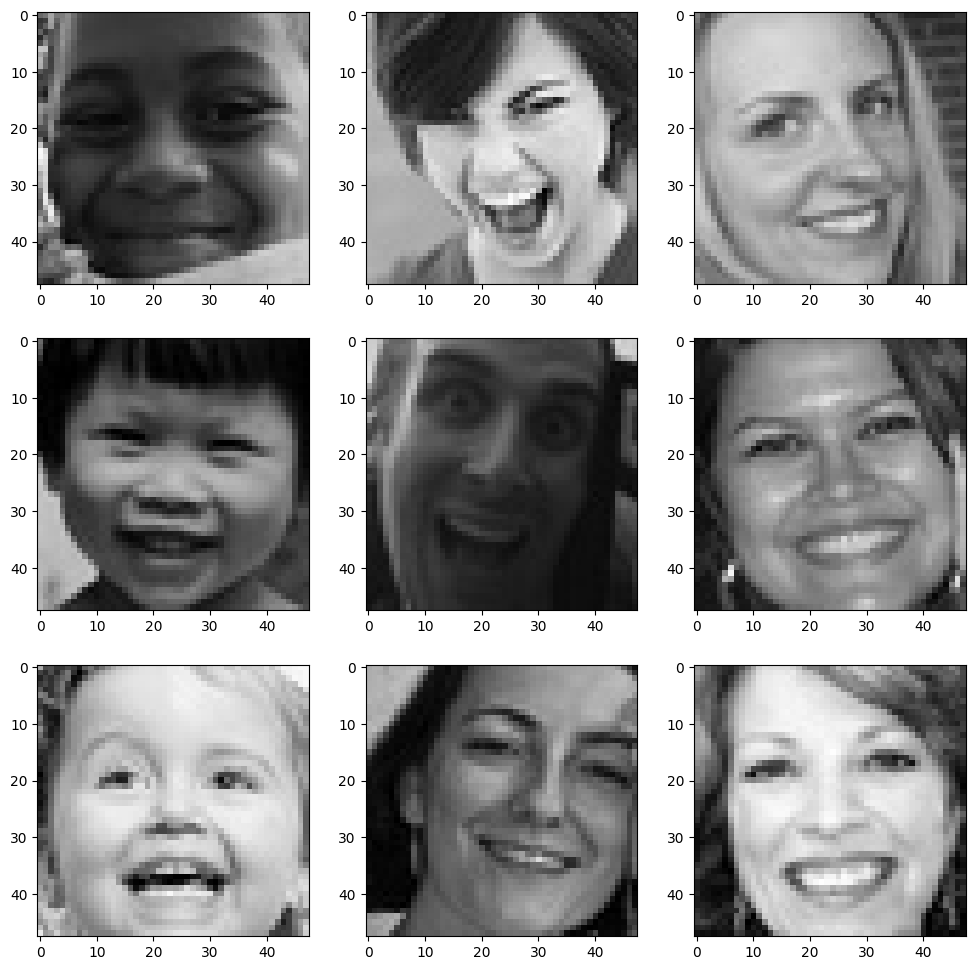

In [86]:
# Step 1: Upload your dataset to Colab
#from google.colab import files
#uploaded = files.upload()

# Step 2: Unzip the dataset (adjust the file name to match the uploaded file)
import zipfile
import os

# The file name should be 'archive.zip' based on your upload
#with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
 #  zip_ref.extractall('your_dataset_folder')  # You can choose a folder name to extract the files into

# Step 3: Set up the folder path and load images
folder_path = "/content/images/"  # Adjust this if needed based on your folder structure after unzipping
expression = 'happy'
picture_size = 48  # or the size you want for your images

plt.figure(figsize=(12, 12))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    # Adjust the path to work with Colab
    img = load_img(folder_path + "train/" + expression + "/" +
                   os.listdir(folder_path + "train/" + expression)[i],
                   target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

# Making Training and Validation Data

In [87]:
batch_size  = 128

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Model Building

In [90]:
from keras.optimizers import Adam,SGD,RMSprop


no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

# Fitting the Model with Training and Validation Data

In [96]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 48

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_set,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    epochs=epochs,
                    validation_data=test_set,
                    validation_steps=test_set.n//test_set.batch_size,
                    callbacks=callbacks_list
                   )

Epoch 1/48


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 1489s 7s/step - accuracy: 0.2546 - loss: 1.9562 - val_accuracy: 0.3631 - val_loss: 1.7375 - learning_rate: 0.0010
Epoch 2/48


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


  1/225 ━━━━━━━━━━━━━━━━━━━━ 20:33 6s/step - accuracy: 0.4062 - loss: 1.5364

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.4062 - loss: 1.5364 - val_accuracy: 0.3462 - val_loss: 1.9135 - learning_rate: 0.0010
Epoch 3/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 1489s 6s/step - accuracy: 0.4323 - loss: 1.4758 - val_accuracy: 0.4778 - val_loss: 1.3746 - learning_rate: 0.0010
Epoch 4/48
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.4844 - loss: 1.4330 - val_accuracy: 0.6538 - val_loss: 1.2792 - learning_rate: 0.0010
Epoch 5/48
111/225 ━━━━━━━━━━━━━━━━━━━━ 11:40 6s/step - accuracy: 0.4922 - loss: 1.3155

# Plotting Accuracy & Loss

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()